In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/kaggle/input/fundus-dataset/dataset.csv')

In [3]:
df

,image_path,class,label_encoded
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
...,...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5


In [4]:
# Görüntüleri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).resize(target_size)  # Görüntüyü yeniden boyutlandır
    image = np.array(image) / 255.0  # Normalizasyon (0-1 aralığına getir)
    return image

In [5]:
# One-hot encoding işlemi
y = to_categorical(df['label_encoded'])

# Görüntüleri ve etiketleri yükleme
X = np.array([load_and_preprocess_image(path) for path in df['image_path']])


In [6]:
# Veriyi eğitim, doğrulama ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # %70 eğitim, %30 geçici
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # %15 doğrulama, %15 test

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)
print("Test verisi şekli:", X_test.shape)

Eğitim verisi şekli: (3158, 224, 224, 3)
Doğrulama verisi şekli: (677, 224, 224, 3)
Test verisi şekli: (677, 224, 224, 3)


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam

# Ortak giriş verisi
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 tabanlı model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_base.output)

# ResNet50 tabanlı model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Özelliklerin birleştirilmesi
combined = concatenate([efficientnet_output, resnet_output])

# Fully connected katmanlar
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

# Model oluşturma
model = Model(inputs=input_tensor, outputs=output)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.losses import CategoricalFocalCrossentropy

for layer in model.layers[-15:]:
    layer.trainable = True

# Cyclical Learning Rate fonksiyonu
def cyclical_learning_rate(epoch, initial_lr=1e-6, max_lr=5e-5, step_size=1000, scale_fn=lambda x: 1 / (2.0 ** (x - 1))):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = initial_lr + (max_lr - initial_lr) * np.maximum(0, (1 - x)) * scale_fn(cycle)
    return lr

# Learning Rate Scheduler tanımla
lr_scheduler = LearningRateScheduler(cyclical_learning_rate)


# Early stopping callback'i tanımla
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Öğrenme oranını dinamik olarak azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)


model.compile(
    optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-3),
    loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, label_smoothing=0.1),
    metrics=['accuracy']
)
# Model eğitimi
# Modeli eğitme
history = model.fit(
    X_train, y_train,                # Eğitim verisi
    batch_size=32,                   # Batch size
    epochs=100,                      # Epoch sayısı
    validation_data=(X_val, y_val),  # Doğrulama verisi
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.2309 - loss: 0.4128 - val_accuracy: 0.1241 - val_loss: 0.4448
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.5048 - loss: 0.2686 - val_accuracy: 0.1374 - val_loss: 0.4392
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 276ms/step - accuracy: 0.5794 - loss: 0.2407 - val_accuracy: 0.1315 - val_loss: 0.4442
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - accuracy: 0.6180 - loss: 0.2251 - val_accuracy: 0.1270 - val_loss: 0.4181
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 276ms/step - accuracy: 0.6564 - loss: 0.2070 - val_accuracy: 0.1610 - val_loss: 0.4151
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - accuracy: 0.7180 - loss: 0.1861 - val_accuracy: 0.1374 - val_loss: 0.4207
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 276ms/step - accuracy: 0.7698 - loss: 0.1635 - val_accuracy: 0.1787 - val_loss: 0.4109
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - accuracy: 0.8172 - loss: 0.1460 - va

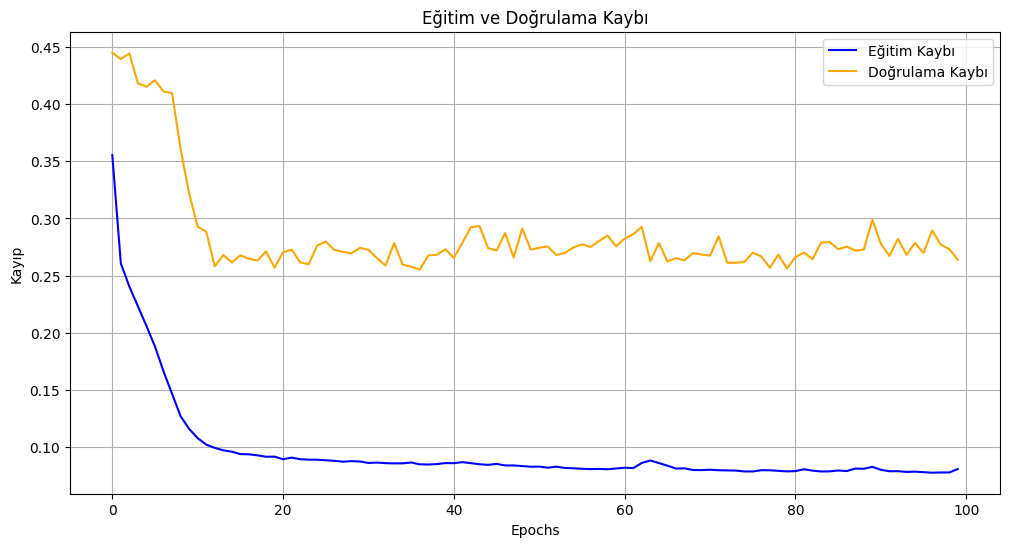

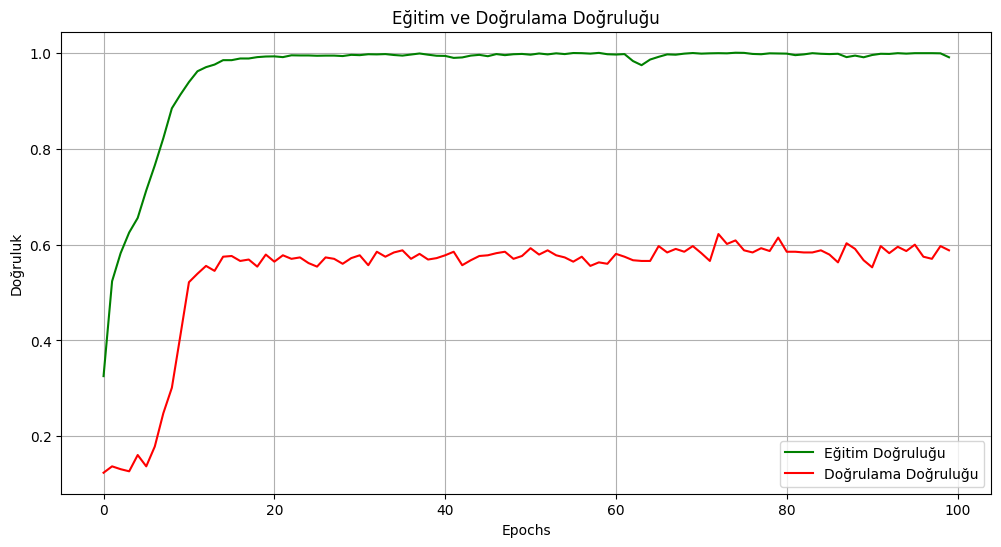

In [16]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybını çizdir
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.grid()
plt.show()

# Eğitim ve doğrulama doğruluğunu çizdir
if 'accuracy' in history.history:  # Model doğruluk metriğini içeriyorsa
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='green')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='red')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Doğruluk metrikleri bulunamadı. Lütfen modelinize doğruluk metriği eklediğinizden emin olun.")


Attention

In [20]:
from tensorflow.keras.layers import Layer, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, add, Activation, Concatenate
import tensorflow.keras.backend as K

class CBAM(Layer):
    def __init__(self, filters, reduction_ratio=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.filters = filters
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Kanal Dikkati için yoğun katmanlar
        self.shared_dense_one = Dense(self.filters // self.reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
        self.shared_dense_two = Dense(self.filters, kernel_initializer='he_normal', use_bias=True)
        
        # Mekansal Dikkat için Conv2D katmanı
        self.spatial_conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
        
        super(CBAM, self).build(input_shape)

    def call(self, inputs):
        # Kanal Dikkati
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = GlobalMaxPooling2D()(inputs)
        avg_pool = Reshape((1, 1, self.filters))(avg_pool)
        max_pool = Reshape((1, 1, self.filters))(max_pool)
        
        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        channel_attention = Activation('sigmoid')(add([avg_out, max_out]))
        channel_refined = multiply([inputs, channel_attention])

        # Mekansal Dikkat
        avg_pool_spatial = K.mean(channel_refined, axis=-1, keepdims=True)
        max_pool_spatial = K.max(channel_refined, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
        
        spatial_attention = self.spatial_conv(concat)  # Conv2D katmanı artık build içinde oluşturuldu
        refined_feature = multiply([channel_refined, spatial_attention])

        return refined_feature

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({"filters": self.filters, "reduction_ratio": self.reduction_ratio})
        return config


In [21]:
# Modeli oluşturma kısmını tekrar çalıştır:
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 tabanlı model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
efficientnet_attention = CBAM(filters=efficientnet_base.output_shape[-1])(efficientnet_base.output)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_attention)

# ResNet50 tabanlı model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_attention = CBAM(filters=resnet_base.output_shape[-1])(resnet_base.output)
resnet_output = GlobalAveragePooling2D()(resnet_attention)

# Özelliklerin birleştirilmesi
combined = concatenate([efficientnet_output, resnet_output])

# Fully connected katmanlar
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

# Model oluşturma ve derleme
model = Model(inputs=input_tensor, outputs=output)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.losses import CategoricalFocalCrossentropy

for layer in model.layers[-15:]:
    layer.trainable = True

# Cyclical Learning Rate fonksiyonu
def cyclical_learning_rate(epoch, initial_lr=1e-6, max_lr=5e-5, step_size=1000, scale_fn=lambda x: 1 / (2.0 ** (x - 1))):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = initial_lr + (max_lr - initial_lr) * np.maximum(0, (1 - x)) * scale_fn(cycle)
    return lr

# Learning Rate Scheduler tanımla
lr_scheduler = LearningRateScheduler(cyclical_learning_rate)


# Early stopping callback'i tanımla
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Öğrenme oranını dinamik olarak azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)


model.compile(
    optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-3),
    loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, label_smoothing=0.1),
    metrics=['accuracy']
)
# Model eğitimi
# Modeli eğitme
history = model.fit(
    X_train, y_train,                # Eğitim verisi
    batch_size=32,                   # Batch size
    epochs=100,                      # Epoch sayısı
    validation_data=(X_val, y_val),  # Doğrulama verisi
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.2158 - loss: 0.3776 - val_accuracy: 0.1241 - val_loss: 0.4331
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.5153 - loss: 0.2626 - val_accuracy: 0.1448 - val_loss: 0.4360
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.5822 - loss: 0.2369 - val_accuracy: 0.1418 - val_loss: 0.4028
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.6191 - loss: 0.2204 - val_accuracy: 0.1684 - val_loss: 0.3960
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.6319 - loss: 0.2111 - val_accuracy: 0.1610 - val_loss: 0.3969
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - accuracy: 0.6799 - loss: 0.1938 - val_accuracy: 0.1817 - val_loss: 0.4024
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - accuracy: 0.7264 - loss: 0.1793 - val_accuracy: 0.2038 - val_loss: 0.3988
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - accuracy: 0.8074 - loss: 0.1561 - va

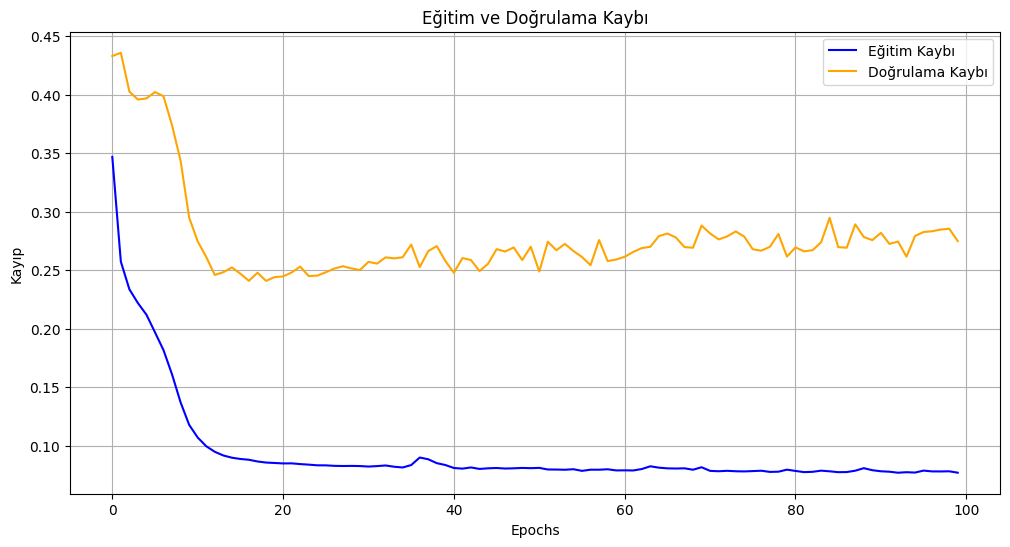

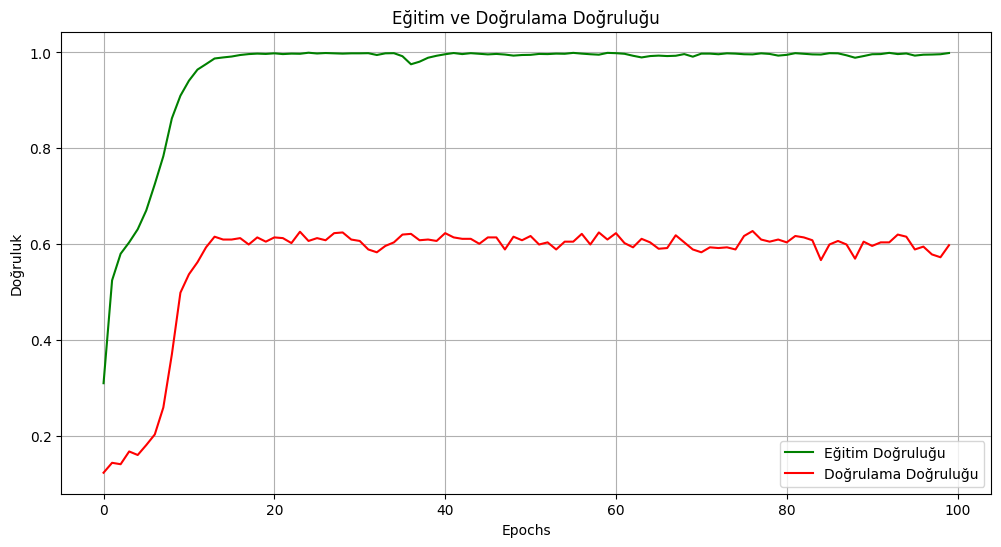

In [23]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybını çizdir
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.grid()
plt.show()

# Eğitim ve doğrulama doğruluğunu çizdir
if 'accuracy' in history.history:  # Model doğruluk metriğini içeriyorsa
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='green')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='red')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Doğruluk metrikleri bulunamadı. Lütfen modelinize doğruluk metriği eklediğinizden emin olun.")
